In [1]:
"""
"""
월 차트 조회
"""
import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,cap,name,exchange
0,005500,1996-01-31,2366,2650,2193,2555,1904146,129574000000,삼진제약,KOSPI
1,012170,1996-01-31,15102505,16027148,12945004,15256612,108,0,아센디오,KOSPI
2,001880,1996-01-31,11099,11573,9960,10340,103110,37596000000,DL건설,KOSPI
3,005750,1996-01-31,1207,1433,1154,1321,1480732,15104000000,대림B&Co,KOSPI
4,012600,1996-01-31,38136,42304,36990,38969,648262,199988000000,센트럴인사이트,KOSPI
...,...,...,...,...,...,...,...,...,...,...
470824,081580,2022-12-02,2785,2850,2780,2805,207266,43499000000,성우전자,KOSDAQ
470825,122640,2022-12-02,8840,8860,8370,8540,102915,154155000000,예스티,KOSDAQ
470826,215360,2022-12-02,15900,16300,15500,15500,156227,141546000000,우리산업,KOSDAQ
470827,299660,2022-12-02,14400,14750,14100,14150,69551,137693000000,셀리드,KOSDAQ


In [1]:
"""

"""
import pandas as pd
import repository.deepsearch as ds
from base import Quarter, YearMonth
import sqlite3

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(".cache/cache.db"))
except Exception as e:
    begin = YearMonth(2001, 4)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df1 = df1[df1["vol"] != 0]
        df1 = df1[df1["cap"] != 0]

        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "확정실적": str(Quarter.last_confirmed(ym1.year, ym1.month)),
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        df["자산"] = ds.load_one("자산", ym1.year, ym1.month)
        df["자본"] = ds.load_one("자본", ym1.year, ym1.month)
        df["매출총이익"] = ds.load_and("매출총이익", ym1.year, ym1.month, 4, sum)
        df["영업이익"] = ds.load_and("영업이익", ym1.year, ym1.month, 4, sum)
        df["당기순이익"] = ds.load_and("당기순이익", ym1.year, ym1.month, 4, sum)
        df["영업활동으로인한현금흐름"] = ds.load_and("영업활동으로인한현금흐름", ym1.year, ym1.month, 4, sum)
        layer1 = pd.concat([layer1, df])

layer1 = layer1.reset_index()
layer1

,index,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매도가,매도일,수익률,A,EQ,GP,O,E,CF
0,0,004830,덕성,KOSPI,2001-04,2001-05,51824000000,2001-04-30,3365,2000-4Q,3390.0,2001-05-31,0.007429,7.234044e+10,3.869468e+10,1.183640e+10,3.411752e+09,3.043678e+09,NaN
1,1,009320,대우부품,KOSPI,2001-04,2001-05,22438000000,2001-04-30,63564,2000-4Q,65928.0,2001-05-31,0.037191,3.169646e+11,6.089978e+10,3.515454e+10,1.991977e+10,9.855770e+08,NaN
2,2,033640,네패스,KOSDAQ,2001-04,2001-05,15642000000,2001-04-30,2390,2000-4Q,2548.0,2001-05-31,0.066109,2.809272e+10,8.006710e+09,3.867476e+09,1.313550e+09,3.808550e+08,NaN
3,3,018290,브이티지엠피,KOSDAQ,2001-04,2001-05,38618000000,2001-04-30,30053,2000-4Q,30194.0,2001-05-31,0.004692,1.021010e+11,3.223555e+10,2.346112e+09,5.217000e+06,4.506810e+08,NaN
4,4,001540,안국약품,KOSDAQ,2001-04,2001-05,22424000000,2001-04-30,1854,2000-4Q,1754.0,2001-05-31,-0.053937,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418185,418185,217820,원익피앤이,KOSDAQ,2022-10,2022-11,105919000000,2022-10-31,9200,2022-2Q,9060.0,2022-11-30,-0.015217,1.131005e+11,5.217515e+10,4.704265e+09,-2.882083e+09,5.307917e+09,3.892735e+09
418186,418186,306040,에스제이그룹,KOSDAQ,2022-10,2022-11,159813000000,2022-10-31,16200,2022-2Q,16000.0,2022-11-30,-0.012346,1.763683e+11,1.196002e+11,1.343016e+11,3.738795e+10,2.929271e+10,3.128252e+10
418187,418187,016670,디모아,KOSDAQ,2022-10,2022-11,48076000000,2022-10-31,472,2022-2Q,634.0,2022-11-30,0.343220,1.048223e+11,7.006464e+10,2.146339e+10,3.020122e+09,-1.722091e+10,-1.813005e+09
418188,418188,039290,인포뱅크,KOSDAQ,2022-10,2022-11,105619000000,2022-10-31,12150,2022-2Q,11700.0,2022-11-30,-0.037037,8.867996e+10,6.628003e+10,1.773814e+10,3.036469e+09,7.931832e+09,6.226878e+09


In [53]:
# layer1.to_sql("layer1", sqlite3.connect(".cache/cache.db"), if_exists="replace")

AttributeError: 'SQLiteDatabase' object has no attribute 'read_table'

In [33]:
layer1 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산": "A",
        "자본": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
        "영업활동으로인한현금흐름": "CF"
    }
)

factors = []
factor = f"1/P"
factors.append(factor)
layer1[factor] = 1 / layer1["P"]

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E", "CF"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer1[factor] = layer1[pos] / layer1[neg]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer1[factor] = layer1[pos] / layer1["P"]

weights_for_super_factor = {
    "1/P_rank": -0.8572277227722772,
    "GP/P_rank": -0.8953290623179965,
    "O/P_rank": -0.48064065230052416,
    "E/P_rank": -0.34069889341875365,
    "CF/P_rank": -0.49431566686080375,
    "GP/A_rank": -0.36336633663366336,
    "O/A_rank": 0.06929528246942342,
    "E/A_rank": 0.21932440302853815,
    "CF/A_rank": -0.2169015725101922,
    "GP/EQ_rank": -0.45951077460687245,
    "O/EQ_rank": 0.08926033779848573,
    "E/EQ_rank": 0.27814793244030284,
    "CF/EQ_rank": -0.314175888177053,
    "A/P_rank": -0.9191962725684333,
    "EQ/P_rank": -0.9172277227722773
}

# weights_for_super_factor = {k: v for k, v in weights_for_super_factor.items() if abs(v) > 0.3}
# print(weights_for_super_factor)

result = pd.DataFrame()
yms = layer1["매수년월"].unique()
rank_scale = 100

for ym in yms:
    df = layer1[layer1["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{factor} {ym}" + " " * 20, end="")
        colname_rank = f"{factor}_rank"
        df[colname_rank] = df[factor].rank(ascending=False, method="min")
        df[colname_rank] = round(df[colname_rank] * rank_scale / df[colname_rank].max())
        df[colname_rank] = df[colname_rank].replace(0, 1)
        if len(df[colname_rank].dropna()) > 0:
            df[colname_rank] = df[colname_rank].fillna(df[colname_rank].median())

    factor = "super"
    colname_rank = factor + "_rank"
    df[factor] = sum([df[colname].dropna() * weight
                      for colname, weight in weights_for_super_factor.items() if len(df[colname].dropna().index) > 0])
    df[colname_rank] = df[factor].rank(ascending=False, method="min")
    df[colname_rank] = round(df[colname_rank] * rank_scale / df[colname_rank].max())

    factor = "1"
    colname_rank = "1_rank"
    df[factor] = df.index
    df[colname_rank] = df[factor].rank(ascending=False, method="min")
    df[colname_rank] = round(df[colname_rank] * rank_scale / df[colname_rank].max())

    result = pd.concat([result, df])

result

EQ/P 2022-10                     

,index,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,확정실적,...,GP/EQ_rank,O/EQ_rank,E/EQ_rank,CF/EQ_rank,A/P_rank,EQ/P_rank,super,super_rank,1,1_rank
0,0,004830,덕성,KOSPI,2001-04,2001-05,51824000000,2001-04-30,3365,2000-4Q,...,53.0,61.0,42.0,NaN,79.0,76.0,-339.782353,88.0,0,100.0
1,1,009320,대우부품,KOSPI,2001-04,2001-05,22438000000,2001-04-30,63564,2000-4Q,...,21.0,9.0,73.0,NaN,17.0,30.0,-116.973384,10.0,1,100.0
2,2,033640,네패스,KOSDAQ,2001-04,2001-05,15642000000,2001-04-30,2390,2000-4Q,...,30.0,36.0,57.0,NaN,71.0,85.0,-287.559476,75.0,2,100.0
3,3,018290,브이티지엠피,KOSDAQ,2001-04,2001-05,38618000000,2001-04-30,30053,2000-4Q,...,93.0,87.0,74.0,NaN,60.0,72.0,-352.933291,91.0,3,100.0
4,4,001540,안국약품,KOSDAQ,2001-04,2001-05,22424000000,2001-04-30,1854,2000-4Q,...,50.0,50.0,50.0,NaN,50.0,50.0,-220.286197,48.0,4,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418185,418185,217820,원익피앤이,KOSDAQ,2022-10,2022-11,105919000000,2022-10-31,9200,2022-2Q,...,85.0,84.0,30.0,39.0,68.0,79.0,-400.584019,88.0,418185,0.0
418186,418186,306040,에스제이그룹,KOSDAQ,2022-10,2022-11,159813000000,2022-10-31,16200,2022-2Q,...,3.0,3.0,5.0,7.0,66.0,62.0,-203.156354,19.0,418186,0.0
418187,418187,016670,디모아,KOSDAQ,2022-10,2022-11,48076000000,2022-10-31,472,2022-2Q,...,41.0,58.0,91.0,70.0,39.0,31.0,-212.494817,21.0,418187,0.0
418188,418188,039290,인포뱅크,KOSDAQ,2022-10,2022-11,105619000000,2022-10-31,12150,2022-2Q,...,49.0,57.0,24.0,33.0,79.0,70.0,-332.343378,73.0,418188,0.0


super_rank,-0.9153174140943506
1_rank,0.10181712288875946
1/P_rank,-0.852997299729973
GP/P_rank,-0.8938013801380138
O/P_rank,-0.4642904290429043
E/P_rank,-0.32248424842484247
CF/P_rank,-0.48144014401440144
GP/A_rank,-0.3562316231623162
O/A_rank,0.04655265526552655
E/A_rank,0.21596159615961597
CF/A_rank,-0.20172817281728173
GP/EQ_rank,-0.44169216921692167
O/EQ_rank,0.09896189618961897
E/EQ_rank,0.26145814581458143
CF/EQ_rank,-0.2984098409840984
A/P_rank,-0.9188478847884789
EQ/P_rank,-0.9129552955295529


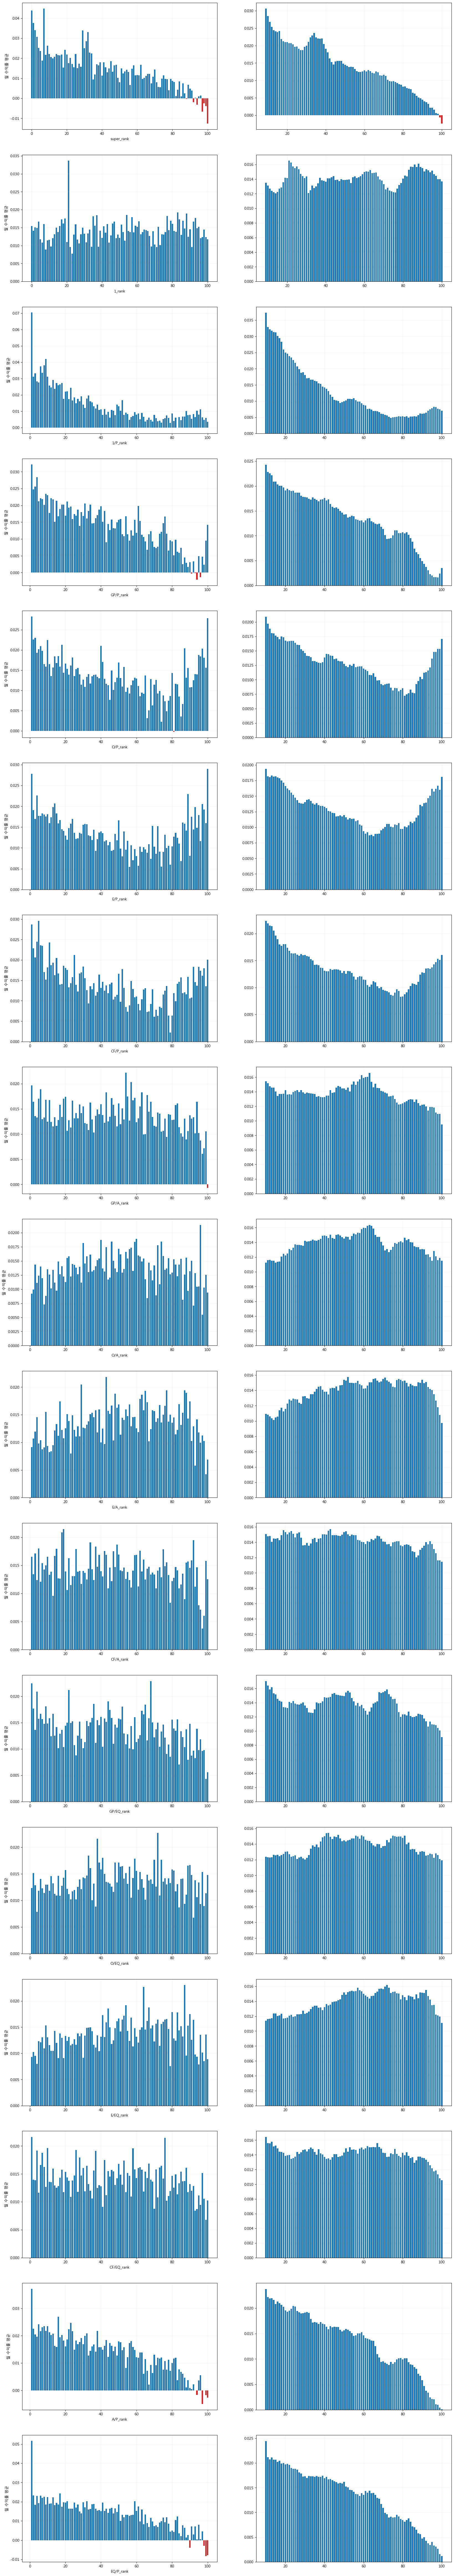

In [34]:
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, subplots = plt.subplots(len(factors) + 2, 2)
fig.set_figwidth(20), fig.set_figheight(8 * len(factors))

weight_by_factor = {}
corr_by_factor = {}
factors2 = ["super", "1"] + factors
for i in range(len(factors2)):
    factor = factors2[i]

    colname_rank = f"{factor}_rank"
    x = sorted(set(result[colname_rank].dropna()))
    y = [result[result[colname_rank] == r]["수익률"] for r in x]

    corr = pd.DataFrame({"x": x, "y": y}).corr(method="spearman")
    weight_by_factor.update({factor: corr})
    corr_by_factor.update({colname_rank: corr["x"]["y"]})

    ax1, ax2 = subplots[i][0], subplots[i][1]
    ax1.set_xlabel(colname_rank)
    ax1.set_ylabel("월 수익률 평균")
    ax1.grid(True)
    ax1.bar(x, y, color=["tab:blue" if v > 0 else "tab:red" for v in y])

    ax2.grid(True)
    y_rolling = pd.Series(y).rolling(10).mean()
    ax2.bar(x, y_rolling, color=["tab:blue" if v > 0 else "tab:red" for v in y_rolling])

for factor, corr in corr_by_factor.items():
    print(",".join([factor, str(corr)]))

In [42]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "1/P"
head = 20
strategy = result.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
result.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))

index    code        종목명     거래소     매수년월     매도년월  \
매수년월    매도년월                                                                  
2001-04 2001-05 161        161  025890       한국주강   KOSPI  2001-04  2001-05   
                208        208  017550      수산중공업   KOSPI  2001-04  2001-05   
                415        415  004565   현대비앤지스틸우   KOSPI  2001-04  2001-05   
                384        384  014285      금강공업우   KOSPI  2001-04  2001-05   
                90          90  001067  JW중외제약2우B   KOSPI  2001-04  2001-05   
...                        ...     ...        ...     ...      ...      ...   
2022-10 2022-11 416240  416240  001527      동양2우B   KOSPI  2022-10  2022-11   
                417954  417954  270210    에스알바이오텍   KONEX  2022-10  2022-11   
                416359  416359  002785     진흥기업우B   KOSPI  2022-10  2022-11   
                417674  417674  021045     대호특수강우  KOSDAQ  2022-10  2022-11   
                416077  416077  000227    유유제약2우B   KOSPI  2022-10  2022-11   

                                 P         매수일    매수가     확정실적  ...  \
매수년월    매도년월                                                    ...   
2001-04 2001-05 161      274000000  2001-04-30     62  2000-4Q  ...   
                208      437000000  2001-04-30    924  2000-4Q  ...   
                415      559000000  2001-04-30   4910  2000-4Q  ...   
                384      571000000  2001-04-30    970  2000-4Q  ...   
                90       636000000  2001-04-30  22717  2000-4Q  ...   
...                            ...         ...    ...      ...  ...   
2022-10 2022-11 416240  4081000000  2022-10-31  13250  2022-2Q  ...   
                417954  4132000000  2022-10-31   3730  2022-2Q  ...   
                416359  4225000000  2022-10-31   4930  2022-2Q  ...   
                417674  4242000000  2022-10-31   1000  2022-2Q  ...   
                416077  4712000000  2022-10-31  14500  2022-2Q  ...   

                        GP/EQ_rank O/EQ_rank  E/EQ_rank  CF/EQ_rank  A/P_rank  \
매수년월    매도년월                                                                    
2001-04 2001-05 161           96.0       8.0        3.0         NaN       1.0   
                208           97.0      53.0        4.0         NaN       1.0   
                415           50.0      50.0       50.0         NaN      50.0   
                384           50.0      50.0       50.0         NaN      50.0   
                90            50.0      50.0       50.0         NaN      50.0   
...                            ...       ...        ...         ...       ...   
2022-10 2022-11 416240        50.0      50.0       50.0        50.0      50.0   
                417954        50.0      50.0       50.0        50.0      50.0   
                416359        50.0      50.0       50.0        50.0      50.0   
                417674        50.0      50.0       50.0        50.0      50.0   
                416077        50.0      50.0       50.0        50.0      50.0   

                        EQ/P_rank       super  super_rank       1  1_rank  
매수년월    매도년월                                                               
2001-04 2001-05 161         100.0 -228.596738        52.0     161    81.0  
                208         100.0 -212.568992        44.0     208    75.0  
                415          50.0 -186.854316        28.0     415    51.0  
                384          50.0 -186.854316        28.0     384    55.0  
                90           50.0 -186.854316        28.0      90    89.0  
...                           ...         ...         ...     ...     ...  
2022-10 2022-11 416240       50.0 -238.123972        29.0  416240    77.0  
                417954       50.0 -238.123972        29.0  417954     9.0  
                416359       50.0 -238.123972        29.0  416359    72.0  
                417674       50.0 -238.123972        29.0  417674    20.0  
                416077       50.0 -238.123972        29.0  416077    83.0  

[5180 rows x 53 columns]

In [43]:
from base import cagr, mdd
from base.time import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

revisions

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2001-04,2001-05,0.122371,0.110465,-0.01,1.122371,1.110465
2001-05,2001-06,-0.001357,0.037129,0.04,1.120848,1.151696
2001-06,2001-07,-0.104704,-0.018212,0.09,1.003490,1.130721
2001-07,2001-08,-0.044066,-0.021023,0.02,0.959271,1.106949
2001-08,2001-09,-0.129828,-0.093574,0.04,0.834730,1.003368
...,...,...,...,...,...,...
2022-06,2022-07,0.062793,-0.028763,-0.09,28.815353,789827.793206
2022-07,2022-08,0.006397,-0.050841,-0.06,28.999684,749672.040660
2022-08,2022-09,-0.147563,0.068505,0.22,24.720390,801028.437726


In [44]:
# CAGR, MDD, Mean
pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])

,CAGR,MDD,Mean
전략,0.880108,"(-0.5643067874559988, (2007-11, 2008-11))",0.071869
벤치마크,0.165243,"(-0.5275277094584514, (2007-07, 2008-10))",0.015146


0.5953822613526807 (-0.3740797958355673, ('2008-05', '2008-10'))
0.1652434325453962 (-0.5275277094584514, ('2007-07', '2008-10'))


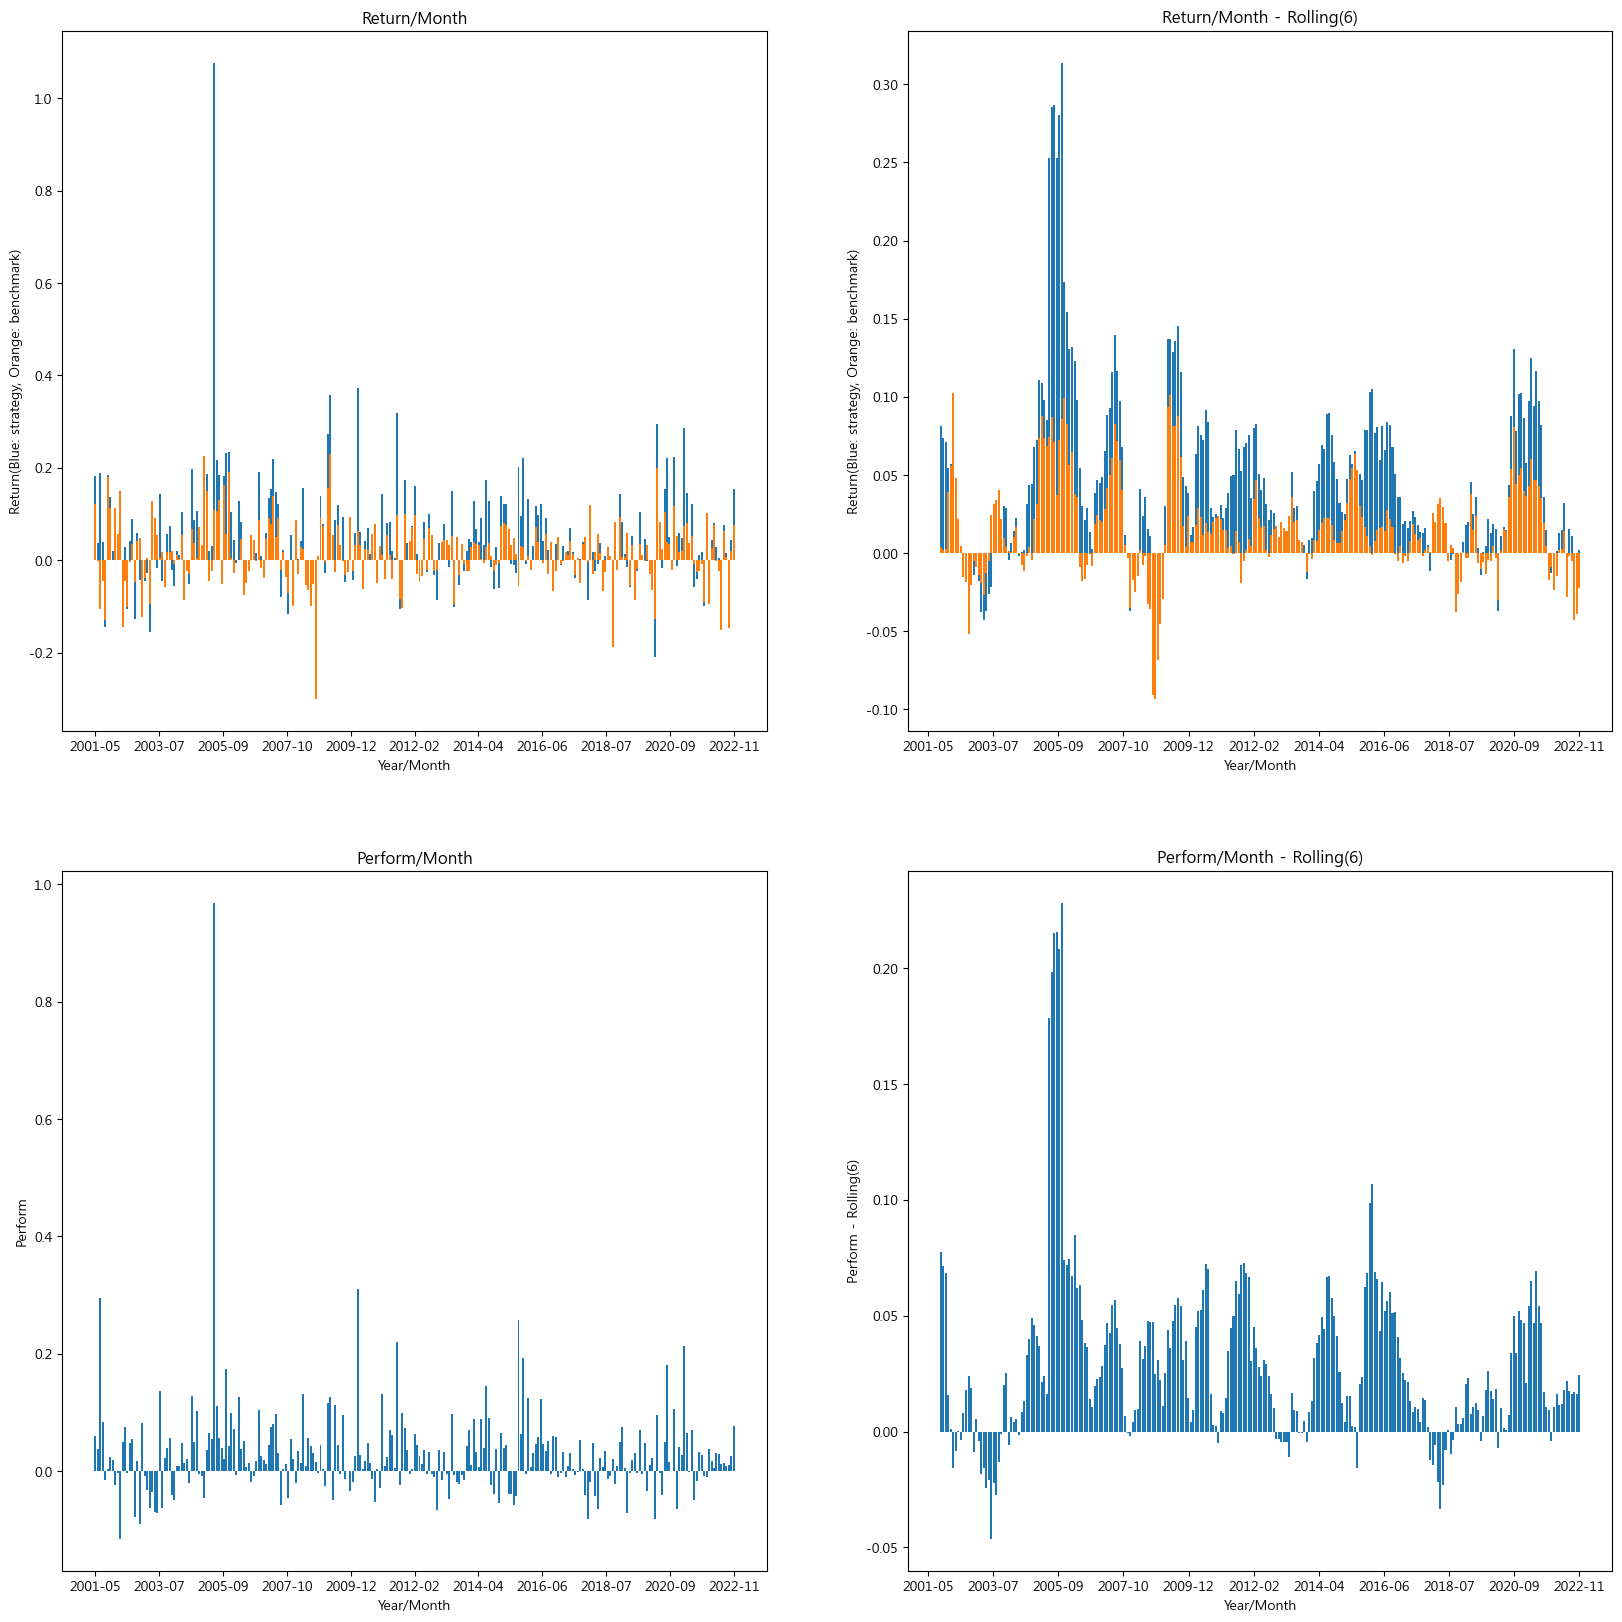

In [91]:
import numpy as np
import matplotlib.pyplot as plt

x = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

x_label = "Year/Month"
y_label = "Return(Blue: strategy, Orange: benchmark)"
ax1.set_title(f"Return/Month")
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))

ax1.bar(x, revisions["전략 수익률"])
ax1.bar(x, revisions["벤치마크 수익률"])

window = 6

ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month"), ax2.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(x, revisions["전략 수익률"].rolling(window).mean())
ax2.bar(x, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title("Perform/Month")
ax3.set_xlabel("Year/Month"), ax3.set_ylabel("Perform")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(x, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax4.set_title("Perform/Month - Rolling(6)")
ax4.set_xlabel("Year/Month"), ax4.set_ylabel("Perform - Rolling(6)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(x, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())